## Imports

In [32]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns

from utilities import df_utils, clustering_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = '../data/raw_data.csv'

df = pd.read_csv(data_path)
df['created_at'] = pd.to_datetime(df['created_at'])
intervals = ['year', 'month']
for interval in intervals:
    df[interval] = getattr(df['created_at'].dt, interval)
df['yearmonth'] = df['year'] * 100 + df['month']
df_utils.df_summarise(df)

(26513, 10)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment', 'year', 'month', 'yearmonth'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment,year,month,yearmonth
0,1158820823102,1399261528126,2019-08-13 03:08:30,3192.00,8700,8700,4,2019,8,201908
1,1856685080638,2733349404734,2019-11-07 06:17:09,135.15,9000,9000,3,2019,11,201911
2,1994825334846,2862876164158,2019-12-25 14:47:26,288.00,8722,8722,3,2019,12,201912
3,2116997972030,2888199700542,2020-02-20 09:15:17,237.00,3650,3650,6,2020,2,202002
4,2155705139262,2992745709630,2020-03-13 22:57:46,208.00,9900,9900,3,2020,3,202003


## Data split

* for `next` use only June - exclude August

In [3]:
prediction_window = df[
    df['created_at'].between(
        pd.Timestamp(2021, 7, 1),
        pd.Timestamp(2021, 7, 30)
    )
].copy()
df_utils.df_summarise(prediction_window)

(2907, 10)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment', 'year', 'month', 'yearmonth'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment,year,month,yearmonth
22480,3977821880382,1389230620734,2021-07-01 03:17:40,260.00,2650,2650,11,2021,7,202107
22481,3977884926014,1390240825406,2021-07-01 04:10:33,229.00,4600,4600,11,2021,7,202107
22482,3977908781118,1390033174590,2021-07-01 04:30:48,294.35,5580,5580,11,2021,7,202107
22483,3977954590782,5215938052158,2021-07-01 04:57:14,323.00,2980,2980,11,2021,7,202107
22484,3977988440126,5215963578430,2021-07-01 05:28:30,118.00,7400,7400,11,2021,7,202107


* for `dset` use 202010 - 202106

In [4]:
behaviour_dataset = df[
    df['created_at'].between(
        pd.Timestamp(2020, 10, 1),
        pd.Timestamp(2021, 6, 30)
    )
].copy()
df_utils.df_summarise(behaviour_dataset)

(22267, 10)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment', 'year', 'month', 'yearmonth'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment,year,month,yearmonth
63,2679892213822,3493717180478,2020-10-01 12:46:56,2445.00,8700,8700,3,2020,10,202010
64,2679964860478,3493777768510,2020-10-01 13:32:38,448.00,5000,5000,3,2020,10,202010
65,2679974887486,3490993078334,2020-10-01 13:38:06,2293.60,6000,6000,3,2020,10,202010
66,2680064802878,3433191145534,2020-10-01 14:28:48,438.95,2800,2800,3,2020,10,202010
67,2680986140734,3494350880830,2020-10-01 21:11:57,399.05,2620,2620,3,2020,10,202010


In [5]:
customer_behaviour = behaviour_dataset.groupby('customer_id')

In [6]:
customers = pd.DataFrame(behaviour_dataset['customer_id'].unique(), columns=['customer_id'])
len(customers)

16599

In [7]:
customers['makes_purchase'] = customers['customer_id'].isin(prediction_window['customer_id'].unique()).astype(int)
customers['makes_purchase'].describe()

count    16599.000000
mean         0.011326
std          0.105822
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: makes_purchase, dtype: float64

### RFM

**Recency**

In [8]:
last_customer_transaction = (customer_behaviour
                                ['created_at'].max()
                                .reset_index()
                                .rename(columns={'created_at': 'last_transaction_date'}))

last_customer_transaction['recency'] = (
    last_customer_transaction['last_transaction_date'].max() - last_customer_transaction['last_transaction_date']
    ).dt.days

df_utils.df_summarise(last_customer_transaction)

(16599, 3)

Index(['customer_id', 'last_transaction_date', 'recency'], dtype='object')

,customer_id,last_transaction_date,recency
0,1385018720318,2021-06-15 08:39:50,14
1,1388893896766,2020-12-10 11:03:06,201
2,1388896190526,2020-11-14 10:07:51,227
3,1388901335102,2021-01-29 08:04:07,151
4,1388901859390,2021-06-08 05:39:32,21


count    16599.000000
mean       143.816073
std         72.760413
min          0.000000
25%         85.000000
50%        159.000000
75%        209.000000
max        271.000000
Name: recency, dtype: float64

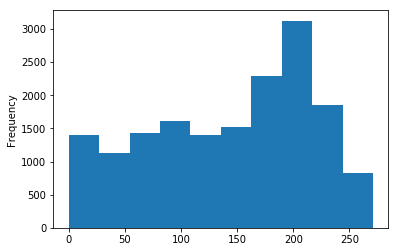

In [9]:
df_utils.show_stats(last_customer_transaction, 'recency')

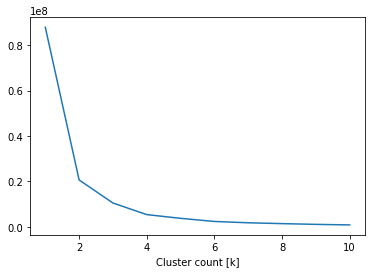

In [10]:
clustering_utils.plot_kmeans_elbow(last_customer_transaction[['recency']])

In [11]:
recency_df = clustering_utils.ordered_clustering(
    last_customer_transaction,
    n_clusters=4,
    cluster_by_column_name='recency', 
    ascending=False
    )

,count,mean,std,min,25%,50%,75%,max
recency_score,,,,,,,,
0,5301.0,222.893982,18.738943,195.0,211.0,217.0,235.0,271.0
1,4526.0,165.880027,16.933055,132.0,152.0,165.0,179.0,194.0
2,3773.0,96.483965,18.015504,64.0,81.0,99.0,111.0,131.0
3,2999.0,30.288429,18.541944,0.0,14.0,28.0,46.0,63.0


**Frequency**

In [12]:
frequency = (
    customer_behaviour
        ['order_id'].count()
        .reset_index()
        .rename(columns={'order_id': 'frequency'})
        )
df_utils.df_summarise(frequency)

(16599, 2)

Index(['customer_id', 'frequency'], dtype='object')

,customer_id,frequency
0,1385018720318,1
1,1388893896766,1
2,1388896190526,1
3,1388901335102,1
4,1388901859390,2


count    16599.000000
mean         1.341466
std          0.681312
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: frequency, dtype: float64

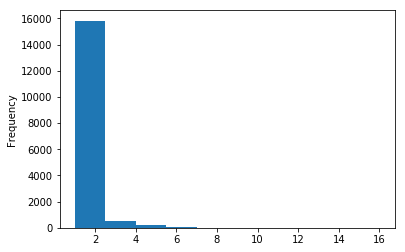

In [13]:
df_utils.show_stats(frequency, 'frequency')

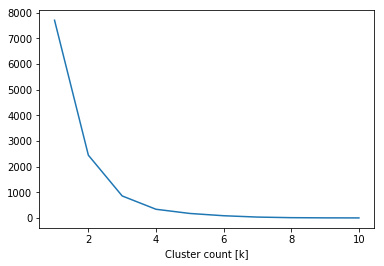

In [14]:
clustering_utils.plot_kmeans_elbow(frequency[['frequency']])

In [15]:
frequency_df = clustering_utils.ordered_clustering(
    frequency,
    n_clusters=4,
    cluster_by_column_name='frequency', 
    ascending=True
    )

,count,mean,std,min,25%,50%,75%,max
frequency_score,,,,,,,,
0,12134.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,3696.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,673.0,3.245171,0.430508,3.0,3.0,3.0,3.0,4.0
3,96.0,5.802083,1.498208,5.0,5.0,5.0,6.0,16.0


**Monetary**

In [16]:
revenue = (customer_behaviour
            ['total_price'].sum()
            .reset_index()
            .rename(columns={'total_price': 'total_revenue'})
            )
df_utils.df_summarise(revenue)

(16599, 2)

Index(['customer_id', 'total_revenue'], dtype='object')

,customer_id,total_revenue
0,1385018720318,0.0
1,1388893896766,158.0
2,1388896190526,208.0
3,1388901335102,54.2
4,1388901859390,356.0


count    16599.000000
mean       500.814159
std        665.791340
min          0.000000
25%        193.990000
50%        338.000000
75%        580.200000
max      35513.800000
Name: total_revenue, dtype: float64

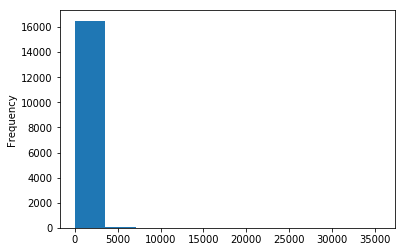

In [17]:
df_utils.show_stats(revenue, 'total_revenue')

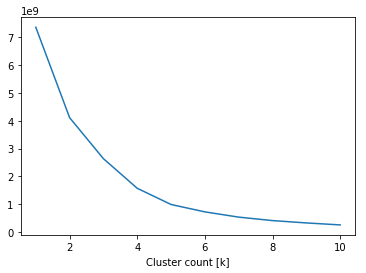

In [18]:
clustering_utils.plot_kmeans_elbow(revenue[['total_revenue']])

In [19]:
revenue_df = clustering_utils.ordered_clustering(
    revenue,
    n_clusters=4,
    cluster_by_column_name='total_revenue', 
    ascending=True
    )

,count,mean,std,min,25%,50%,75%,max
total_revenue_score,,,,,,,,
0,14208.0,329.091425,179.636763,0.00,183.15,292.2,438.95,820.90
1,2260.0,1314.387173,487.205954,821.78,947.00,1116.0,1570.60,3010.58
2,129.0,4726.716744,1930.559600,3030.10,3410.50,3992.0,5189.60,13133.25
3,2.0,28510.900000,9903.596156,21508.00,25009.45,28510.9,32012.35,35513.80


**RFM Score**

In [20]:
features = (
    customers
    .merge(recency_df, how='left', on='customer_id')
    .merge(frequency_df, how='left', on='customer_id')
    .merge(revenue_df, how='left', on='customer_id')
    )
features['rfm_score'] = features['recency_score'] + features['frequency_score'] + features['total_revenue_score']
features.groupby('rfm_score').agg(['mean', 'count'])[['recency','frequency','total_revenue']]


recency        frequency       total_revenue      
                 mean count       mean count          mean count
rfm_score                                                       
0          223.003084  4540   1.000000  4540    311.533084  4540
1          174.787320  4227   1.054649  4227    387.760043  4227
2          117.329962  3164   1.151707  3164    423.211934  3164
3           81.909827  1730   1.547399  1730    609.073572  1730
4           42.627145  1923   2.062402  1923    623.953500  1923
5           42.389831   708   2.498588   708   1277.274449   708
6           39.319635   219   3.433790   219   1839.270046   219
7           27.972973    74   4.864865    74   3081.583378    74
8           25.500000    12   6.500000    12   6235.040833    12
9           18.000000     2  11.500000     2  28510.900000     2

In [21]:
get_rfm_segment = lambda rfm_score: 'high' if rfm_score >= 5 else 'mid' if rfm_score > 3 else 'low'

features['rfm_segment'] = features['rfm_score'].apply(get_rfm_segment)
features.groupby('rfm_segment').agg(['mean', 'count'])[['recency','frequency','total_revenue']]

recency        frequency        total_revenue       
                   mean  count      mean  count          mean  count
rfm_segment                                                         
high          40.428571   1015  2.937931   1015   1642.354591   1015
low          165.741600  13661  1.121367  13661    398.664940  13661
mid           42.627145   1923  2.062402   1923    623.953500   1923

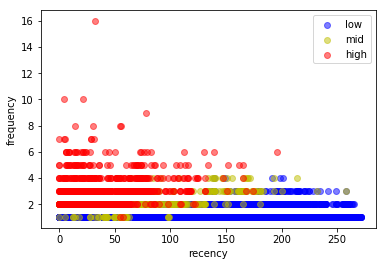

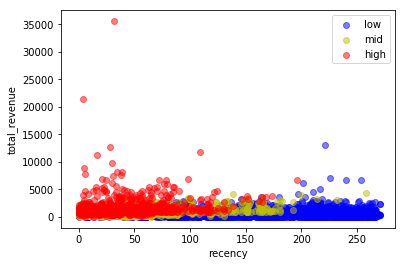

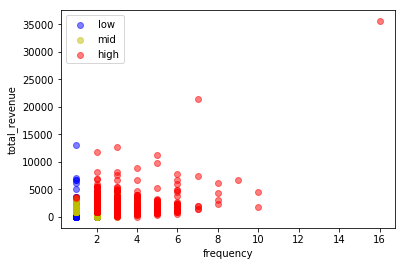

In [23]:
def scatterplot_segments(df: DataFrame, segment_column_name: str, feature_1: str, feature_2: str):
    """
    Shows segmentation scatterplot
    """
    segments = df[segment_column_name].unique()
    plt.figure()
    for segment in segments:
        color = 'r' if segment == 'high' else 'y' if segment == 'mid' else 'b'
        segment_df = df[df[segment_column_name] == segment]
        plt.scatter(segment_df[feature_1], segment_df[feature_2], c=color, alpha=0.5, label=segment)
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.legend()
    plt.show()

scatterplot_segments(features, 'rfm_segment', 'recency', 'frequency')
scatterplot_segments(features, 'rfm_segment', 'recency', 'total_revenue')
scatterplot_segments(features, 'rfm_segment', 'frequency', 'total_revenue')

### Geographical

In [24]:
zip_codes = behaviour_dataset[['customer_id', 'billing_zip']].drop_duplicates(subset='customer_id')
zip_codes['billing_zip_stem'] = zip_codes['billing_zip'].apply(df_utils.get_zip_code_stem)

features = features.merge(
    zip_codes[['customer_id', 'billing_zip_stem']], 
    how='left', 
    on='customer_id'
    )

df_utils.df_summarise(features)


(16599, 12)

Index(['customer_id', 'makes_purchase', 'last_transaction_date', 'recency',
       'recency_score', 'frequency', 'frequency_score', 'total_revenue',
       'total_revenue_score', 'rfm_score', 'rfm_segment', 'billing_zip_stem'],
      dtype='object')

,customer_id,makes_purchase,last_transaction_date,recency,recency_score,frequency,frequency_score,total_revenue,total_revenue_score,rfm_score,rfm_segment,billing_zip_stem
0,3493717180478,0,2020-10-01 12:46:56,271,0,1,0,2445.00,1,1,low,87
1,3493777768510,0,2020-10-01 13:32:38,271,0,1,0,448.00,0,0,low,50
2,3490993078334,0,2020-10-01 13:38:06,271,0,1,0,2293.60,1,1,low,60
3,3433191145534,0,2020-10-01 14:28:48,271,0,1,0,438.95,0,0,low,28
4,3494350880830,0,2020-10-01 21:11:57,271,0,1,0,399.05,0,0,low,26


### Segmentation

In [25]:
features = features.merge(customer_behaviour['segment'].max(), how='left', on='customer_id')

features[['rfm_score', 'segment']].corr()

,rfm_score,segment
rfm_score,1.000000,0.292921
segment,0.292921,1.000000


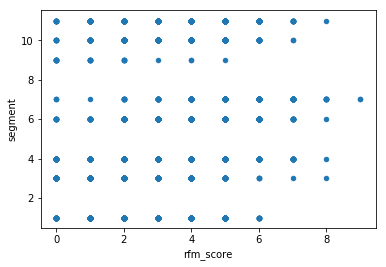

In [26]:
features[['rfm_score', 'segment']].plot.scatter(x='rfm_score', y='segment');

In [31]:
features.to_csv('../data/features.csv')

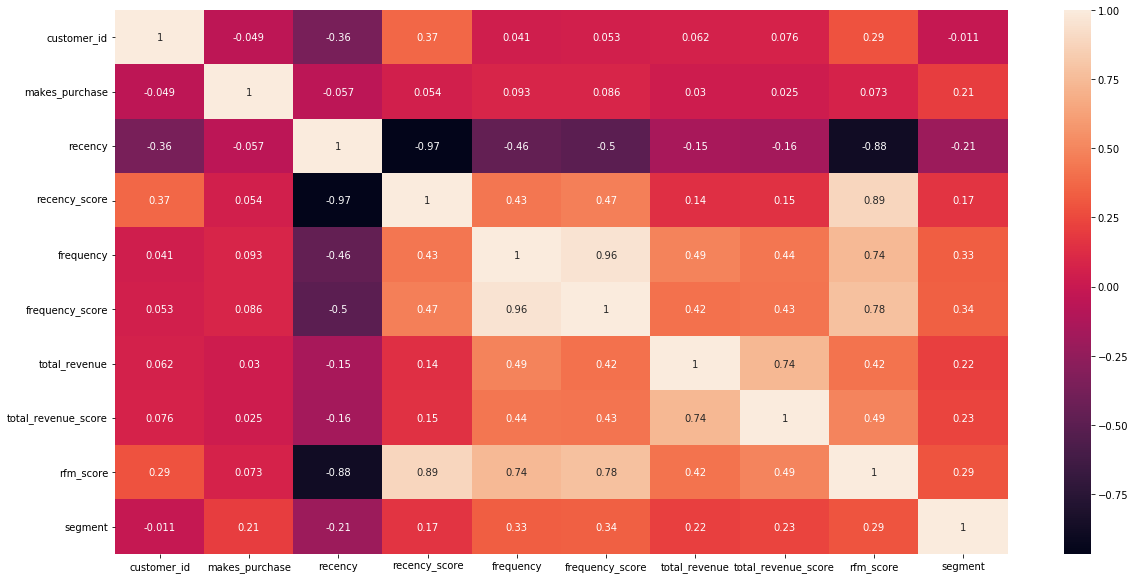

In [35]:
plt.figure(figsize=(20,10))
sns.heatmap(features.corr(), annot=True);